In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno # pip3 install missingno
import seaborn as sns 
sns.set_style("whitegrid")
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## 1. Load Data

In [2]:
df=pd.read_csv("sothebys.csv", index_col=0)

In [4]:
#convert datatime columns
df.start_date =pd.to_datetime(df.start_date)
df.end_date =pd.to_datetime(df.end_date)

In [5]:
# Check Auction length
cnt=np.where(df["end_date"]!=df["start_date"],1,0).sum()
#cnt=0
df.drop("end_date",axis=1,inplace=True)

Therefore, we'll use $start\_date$ as the time that the auction occured going forward. 

In [6]:
#clean up birth_year
df.birth_year=pd.to_numeric(df.birth_year,errors='coerce').astype(float)

## 2. Add Features

In [7]:
# Add year, month and season for auction time
df["auc_date"] = pd.DatetimeIndex(df.start_date).normalize()
df['auc_year'] = pd.DatetimeIndex(df['start_date']).year
df['auc_month'] = pd.DatetimeIndex(df['start_date']).month
df['auc_season'] = df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)

In [8]:
# Add a boolean column to indicate if the lot is named "untitled"
words='|'.join(["INTITULADO","UNTITLED","OHNE TITEL","SANS TITRE","SENZA TITOLO"])
df["is_untitled"]=np.where(df["lot_title"].str.contains(words), 1, 0)

In [9]:
# Normalize "nth_in_auction" column by "auction_id" into 10 tiles
df["auc_order"]= df.groupby("auction_id")["nth_in_auction"].transform(
                     lambda x: pd.qcut(x, 10, labels=range(1,11))) 

In [10]:
# returns nth_in_auction divided by lot_number = percentage through the auction the lot when lot was shown
lot_order_df = df[['nth_in_auction', 'number_of_lots']].copy()
df['percent_in_auction'] = np.round(lot_order_df.nth_in_auction / lot_order_df.number_of_lots, 3)*100

In [11]:
# Add avg_estimate
df["estimate_avg"]=(df["estimate_low"] + df["estimate_high"])/2

## 3. Convert Currency

In [12]:
# pip install --user currencyconverter
from currency_converter import CurrencyConverter
from datetime import datetime
c = CurrencyConverter(fallback_on_wrong_date=True, fallback_on_missing_rate=True)

hammer_price = df[['hammer_price_bp', 'currency', 'start_date']].copy()
est_low = df[['estimate_low', 'currency', 'start_date']].copy()
est_high = df[['estimate_high', 'currency', 'start_date']].copy()
est_avg = df[['estimate_avg', 'currency', 'start_date']].copy()

hammer_price.start_date = hammer_price.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_low.start_date = est_low.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_high.start_date = est_high.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_avg.start_date = est_avg.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)

df['hammer_price_bp_usd'] = hammer_price.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_low_usd'] = est_low.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)    
df['estimate_high_usd'] = est_high.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_avg_usd'] = est_avg.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)

In [13]:
df['hammer_price_bp_usd'].describe()

count    1.881000e+04
mean     3.117394e+05
std      1.872662e+06
min      0.000000e+00
25%      8.894665e+03
50%      3.136310e+04
75%      1.116989e+05
max      7.941250e+07
Name: hammer_price_bp_usd, dtype: float64

In [14]:
# Add converted Hammer Price Range
def price_range(x):

    if x <10000:
        return "0-$10,000"
    elif x<50000:
        return "10,001-$50,000"
    elif x <500000:
        return "50,001-$500,000"
    else: return "$500,000+"
df["hammer_price_bp_usd_range"] = df["hammer_price_bp_usd"].apply(price_range)

In [15]:
df.sample(20)

,lot_id,auction_id,lot_title,estimate_low,estimate_high,hammer_price_bp,currency,nth_in_auction,lot_number,condition,provenance,literature,external_image_url,auction_house_id,auc_title,number_of_lots,location,start_date,auc_desc,sale_id,artist_id,name,birth_year,death_year,auc_date,auc_year,auc_month,auc_season,is_untitled,auc_order,percent_in_auction,estimate_avg,hammer_price_bp_usd,estimate_low_usd,estimate_high_usd,estimate_avg_usd,hammer_price_bp_usd_range
12586,8573,79,KALO,5000.0,7000.0,5000.0,USD,336,371,This work is in good condition overall. The ca...,Acquired by the present owner in 2007,NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Curated featuring works from “In ...,343,NEW YORK,2017-03-02 15:00:00.695,Results: The March Contemporary Curated sale f...,N09622,3395,Lita Cabellut,1961.0,NaN,2017-03-02,2017,3,2,0,10,98.0,6000.0,5000.00,5000.00,7000.00,6000.00,"0-$10,000"
12964,12069,110,MYTHS: DRACULA,8000.0,12000.0,51650.0,GBP,1,101,Colour: \nThe colours in the catalogue illustr...,"Frayda Feldman &amp; Jörg Schellmann, <em>Andy...",NaN,http://www.sothebys.com/content/dam/default/un...,1,The Gunter Sachs Collection Day Auction,246,LONDON,2012-05-23 09:30:00.333,"RESULTS\n\nLONDON, 23 May 2012 - Today’s Day S...",L12027,79,Andy Warhol,1928.0,1987,2012-05-23,2012,5,2,0,1,0.4,10000.0,81282.61,12589.76,18884.63,15737.20,"50,001-$500,000"
3013,17950,111,NaN,200.0,300.0,1250.0,EUR,470,557,"Overall condition reasonable, dents, marks and...","<p>J.M.W. van Voorst tot Voorst, <em>Tussen Bi...",NaN,http://www.sothebys.com/content/dam/stb/lots/A...,1,Property from the Estate of Queen Juliana of T...,1539,AMSTERDAM,2011-03-14 13:00:00.000,OVERVIEW\n\nSotheby's Amsterdam is honoured to...,M1100,6728,"A Dutch brass-inlaid rosewood open bookcase, J...",NaN,NaN,2011-03-14,2011,3,2,1,3,30.5,250.0,1743.50,278.96,418.44,348.70,"0-$10,000"
2686,18121,111,NaN,1500.0,2000.0,36750.0,EUR,557,646,"Rather good condition, stained, gilding with s...",Paleis Lange Voorhout,NaN,http://www.sothebys.com/content/dam/stb/lots/A...,1,Property from the Estate of Queen Juliana of T...,1539,AMSTERDAM,2011-03-14 13:00:00.000,OVERVIEW\n\nSotheby's Amsterdam is honoured to...,M1100,6871,A large and attractive French gilt bronze and ...,NaN,NaN,2011-03-14,2011,3,2,1,4,36.2,1750.0,51258.90,2092.20,2789.60,2440.90,"50,001-$500,000"
11128,9627,129,PAYSAGE À LA HAVANESIGNED 'PASCIN' (LOWER RIGH...,2000.0,2500.0,2500.0,EUR,18,18,"Executed on cream wove paper, laid down on the...",L'authenticité&nbsp;de cette oeuvre a été conf...,NaN,http://www.sothebys.com/content/dam/stb/lots/P...,1,Now !,183,PARIS,2015-07-01 14:00:00.573,RESULTS\n\nOur first Now ! sale was a great su...,F1524,3827,Jules Pascin,1885.0,1930,2015-07-01,2015,7,3,0,2,9.8,2250.0,2775.00,2220.00,2775.00,2497.50,"0-$10,000"
21437,1174,11,UNTITLED,80000.0,120000.0,181000.0,USD,77,78,This painting is in a perfect state. It is un...,"Tang Contemporary Art Center, Beijing and Bang...",NaN,http://www.sothebys.com/content/dam/default/un...,1,"Contemporary Art Asia: China, Korea, Japan",274,NEW YORK,2007-09-20 14:00:00.000,NaN,N08343,406,Zeng Fanzhi,1964.0,NaN,2007-09-20,2007,9,4,1,3,28.1,100000.0,181000.00,80000.00,120000.00,100000.00,"50,001-$500,000"
1652,20216,200,UNTITLED,8000.0,12000.0,20000.0,USD,203,242,This work is in very good condition overall. ...,"Arthur Tooth &amp; Sons, London<br>Acquired by...",This work is registered in the Sam Francis Fou...,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art,300,NEW YORK,2011-03-09 15:00:00.000,OVERVIEW\n\nThe 9th of March Contemporary Auct...,N08720,97,Sam Francis,1923.0,1994,2011-03-09,2011,3,2,1,6,67.7,10000.0,20000.00,8000.00,12000.00,10000.00,"10,001-$50,000"
10811,12801,149,PAYSAGE DE PROVENCE (GRIGNAN)OIL ON CANVAS. EX...,150000.0,200000.0,205500.0,EUR,1,1,The colours are fairly accurate in the catalog...,Acquis directement auprès de l'artiste et tran...,NaN,http://www.sothebys.com/content/dam/default/un...,1,A

## 4. Export to CSV

In [16]:
df.to_csv("final_sothebys.csv")

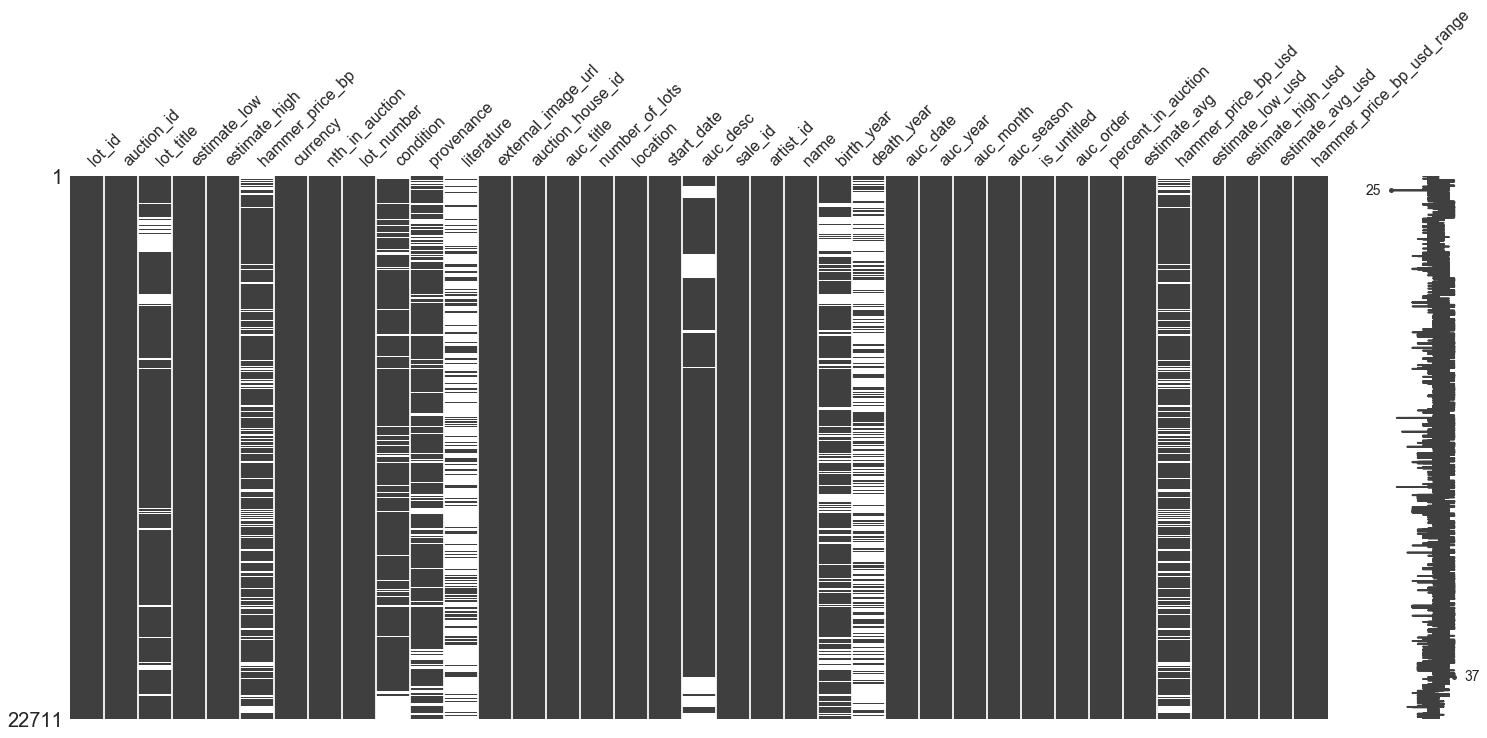

In [56]:
msno.matrix(df)

In [17]:
#check 
#change the 100% thing
#paracord- interactive
temp=df.groupby("auc_id").size()

KeyError: 'auc_id'